In [2]:
import os
import pandas as pd

PATH = "/home/haasehelen/haasehelen/ifwaste/analysis/waste_results/"
DATA_PATH = "/blue/carpena/haasehelen/ifwaste/output/multiple_stores/"

#os.environ["PATH"] = "E:/UF/ifwaste/data/"


food_categories = [
    'Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods', 'Baked Goods',
    'Snacks, Condiments, Liquids, Oils, Grease, & Other', 'Store-Prepared Items'
]

fg_names = ["FGMEAT","FGDAIRY","FGVEGETABLE","FGDRYFOOD","FGBAKED","FGSNACKS","FGSTOREPREPARED"]

lookup_df = pd.DataFrame({
    'Legend_name': food_categories,
    'Fg_name' : fg_names,
    'Servings_to_kg': [0.089, 0.146, 0.112, 0.076, 0.055, 0.071, 0.100],
    #"Color": ["#41afaa", "#00a0e1", "#466eb4", "#e6a532", "#d7642c","#af4b91"]
    "Color": ["#FFC446","#D66D10","#A40E4C","#2C2C54","#638EB5","#2F8550","#2C4A26"]
})
# Define a color palette for the different statuses
status_colors = {
            "Prepared": "#5FAD56",
            "Unprepared": "#F2C14E",
            "Preprepared": "#F78154",
            # Add more status colors if needed
        }
reason_colors = {
            "Inedible Parts": "#26547C",
            "Plate Waste": "#FFD166",
            "Spoiled Food": "#EF476F",
            # Add more status colors if needed
        }
#colors = ["#26547C", "#e6aa20", "#c71e47", "#466eb4"]


DAYS = 114
    
color_mapping = dict(zip(lookup_df['Legend_name'], lookup_df['Color']))

In [3]:
fg_names

['FGMEAT',
 'FGDAIRY',
 'FGVEGETABLE',
 'FGDRYFOOD',
 'FGBAKED',
 'FGSNACKS',
 'FGSTOREPREPARED']

In [4]:
import os
import pandas as pd


CURR_EXP = "run_1/"
file_names = ['log_bought', 'log_eaten', 'log_wasted', 'log_hh_config', "log_still_have",
                "log_hh_daily", "log_sim_config", "log_store_daily", "aggregated_outputs"]
#file_names = ["aggregated_outputs"]
data_dict = {}
current_path = os.path.join(DATA_PATH + CURR_EXP)
for file in file_names:
    file_path = os.path.join(current_path + file + ".csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["run"] = 0
        if "day" in df.columns:
            df["day"] = df["day"].astype(int)
        data_dict[file] = df

In [5]:
wasted = data_dict["log_wasted"]
eaten = data_dict["log_eaten"]

In [6]:
len(wasted)

3724667

In [ ]:
hhID = 3

In [8]:
eaten = eaten.astype({col: float for col in eaten.columns if col not in ["day", "household", "status", "reason"]})
eaten["household"] = eaten["household"].astype(int)
eaten["day"] = eaten["day"].astype(int)

for food in fg_names:
    conversion_factor = lookup_df.loc[lookup_df["Fg_name"] == food, "Servings_to_kg"].values[0]
    eaten.loc[:, food] = eaten[food] * conversion_factor

eaten["kg"] = eaten[fg_names].sum(axis=1)

In [9]:
wasted = wasted.astype({col: float for col in wasted.columns if col not in ["day", "household", "status", "reason"]})
wasted["household"] = wasted["household"].astype(int)
wasted["day"] = wasted["day"].astype(int)

for food in fg_names:
    conversion_factor = lookup_df.loc[lookup_df["Fg_name"] == food, "Servings_to_kg"].values[0]
    wasted.loc[:, food] = wasted[food] * conversion_factor

wasted["kg"] = wasted[fg_names].sum(axis=1)

In [10]:
import matplotlib.pyplot as plt

def plot_waste_type_hh(df_wasted, hhID):
    # Filter for the specified household and positive waste
    hh_wasted = df_wasted[(df_wasted['household'] == hhID) & (df_wasted["kg"] > 0)]
    hh_wasted_grouped = hh_wasted.groupby(["day", "status"])["kg"].sum().unstack(fill_value=0)
    hh_wasted_grouped = hh_wasted_grouped.sort_index()

    plt.figure(figsize=(20, 10), dpi=300)      
    hh_wasted.plot(kind='bar', stacked=True, color=status_colors, ax=plt.gca())
    
    plt.xlabel("Day", fontsize=18)
    plt.xlim(0,DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("Kg", fontsize=18)
    plt.legend(title="Status", fontsize=18, title_fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [11]:
hh_wasted = wasted[(wasted['household'] == hhID) & (wasted["kg"] > 0)]
hh_wasted = hh_wasted.groupby(["day", "status"])["kg"].sum()
hh_wasted = hh_wasted.unstack(fill_value=0)
print(len(hh_wasted),hh_wasted.head())
hh_wasted = hh_wasted.reindex(columns=status_colors.keys(), fill_value=0)

112 status  Prepared  Preprepared  Unprepared
day                                      
0       0.188564       0.0041    0.424436
1       0.195723       0.0000    0.575234
2       0.185141       0.0000    0.248098
3       0.179396       3.3711    0.199716
4       0.142015       0.0000    0.026344


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_food_group_waste_hh(df, hhID):
    # Filter and compute if needed (if Dask)
    df_filtered = df[(df['household'] == hhID) & (df["kg"] > 0)]

    # Group by day, summing over all FG columns
    df_grouped = df_filtered.groupby('day')[fg_names].sum().reset_index()

    # Rename FG codes to readable names
    rename_map = dict(zip(fg_names, food_categories))
    df_grouped = df_grouped.rename(columns=rename_map)

    # Get colors in the correct order
    plot_colors = [color_mapping[cat] for cat in food_categories]
    # Plot
    ax = df_grouped.plot(
        kind='bar',
        stacked=True,
        x='day',
        figsize=(20, 10),
        color=plot_colors,
        width=0.7,
        edgecolor='none'
    )

    plt.xlabel("Day", fontsize=18)
    plt.xlim(0, DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("Waste in kg", fontsize=18)
    plt.legend(
        title='Food Groups',
        fontsize=14,
        title_fontsize=16,
        loc='upper right',
        bbox_to_anchor=(1, 1)
    )
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
#plot_food_group_waste_hh(wasted, 1)

In [13]:
import matplotlib.pyplot as plt
import dask.dataframe as dd

def plot_reason_type_hh(df_wasted, hhID):
    
    # Create a subplot for each level of concern range
    plt.figure(figsize=(20, 10), dpi=300)        
    hh_wasted = df_wasted[(df_wasted['household'] == hhID) & (df_wasted["kg"] > 0)]
    hh_wasted = hh_wasted.groupby(["day", "reason"])["kg"].sum()
    hh_wasted = hh_wasted.compute().unstack(fill_value=0).reindex(columns=reason_colors.keys(), fill_value=0)
    hh_wasted.plot(kind='bar', stacked=True, color=[reason_colors.get(reason, 'gray') for reason in hh_wasted.columns], ax=plt.gca())
    plt.xlabel("day", fontsize=18)
    plt.xlim(0,DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("kg", fontsize=18)
    plt.legend(title="Disposal Reason", fontsize=18, title_fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

wasted_dask = dd.from_pandas(wasted)
#plot_reason_type_hh(wasted_dask,1)

In [14]:
import matplotlib.pyplot as plt
import dask.dataframe as dd

def plot_status_type_hh(df_wasted, hhID):
    
    # Create a subplot for each level of concern range
    plt.figure(figsize=(20, 10), dpi=300)        
    hh_wasted = df_wasted[(df_wasted['household'] == hhID) & (df_wasted["kg"] > 0)]
    hh_wasted = hh_wasted.groupby(["day", "status"])["kg"].sum()
    hh_wasted = hh_wasted.compute().unstack(fill_value=0).reindex(columns=status_colors.keys(), fill_value=0)
    hh_wasted.plot(kind='bar', stacked=True, color=[status_colors.get(status, 'gray') for status in hh_wasted.columns], ax=plt.gca())
    plt.xlabel("day", fontsize=18)
    plt.xlim(0,DAYS)
    plt.xticks(range(0, DAYS + 1, 10)) 
    plt.ylabel("kg", fontsize=18)
    plt.legend(title="Food Status", fontsize=18, title_fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
#plot_status_type_hh(wasted_dask,1)

In [15]:
## Bought vs Eaten vs Disposed --------

In [16]:
import numpy as np
import matplotlib.pyplot as plt
num_vars = len(fg_names)

# Set up angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# --- Example input (use real DFs instead) ---
df_bought = data_dict["log_bought"][data_dict["log_bought"]["household"] == hhID]
df_eaten = eaten[eaten["household"] == hhID]
df_wasted = wasted[wasted["household"] == hhID]

In [17]:
def summarize(df):
    valid_cols = [col for col in fg_names if col in df.columns]
    return df[valid_cols].sum()

def summarize_long(df):
    # Filter for household
    df = df.copy()

    # Create a lookup mapping: type (FG name) → Servings_to_kg
    conversion_map = lookup_df.set_index("Fg_name")["Servings_to_kg"]

    # Map the conversion factor to each row using 'type' column
    df["servings_to_kg"] = df["type"].map(conversion_map)

    # Calculate kg: amount * servings * servings_to_kg
    df["kg"] = df["amount"] * df["servings"] * df["servings_to_kg"]
    # Group by food group type and sum kg
    summary = df.groupby("type")["kg"].sum()

    # Reindex to include all FG categories even if missing
    summary = summary.reindex(conversion_map.index, fill_value=0)

    return summary



In [18]:
   # TODO: replace scale with dynamic value

# Summarize per category
bought_sum = summarize_long(df_bought)
ate_sum = summarize(df_eaten)
wasted_sum = summarize(df_wasted)

In [19]:
bought_sum

Fg_name
FGMEAT             18.245
FGDAIRY            44.968
FGVEGETABLE        17.472
FGDRYFOOD          20.900
FGBAKED            15.730
FGSNACKS           30.317
FGSTOREPREPARED    62.100
Name: kg, dtype: float64

In [20]:
ate_sum

FGMEAT              9.014454
FGDAIRY            32.052694
FGVEGETABLE         8.286544
FGDRYFOOD          13.436800
FGBAKED            11.566775
FGSNACKS           22.338659
FGSTOREPREPARED    26.079000
dtype: float64

In [21]:
wasted_sum

FGMEAT              8.309752
FGDAIRY            11.967766
FGVEGETABLE         7.791056
FGDRYFOOD           5.770908
FGBAKED             3.525445
FGSNACKS            6.822532
FGSTOREPREPARED    36.020000
dtype: float64

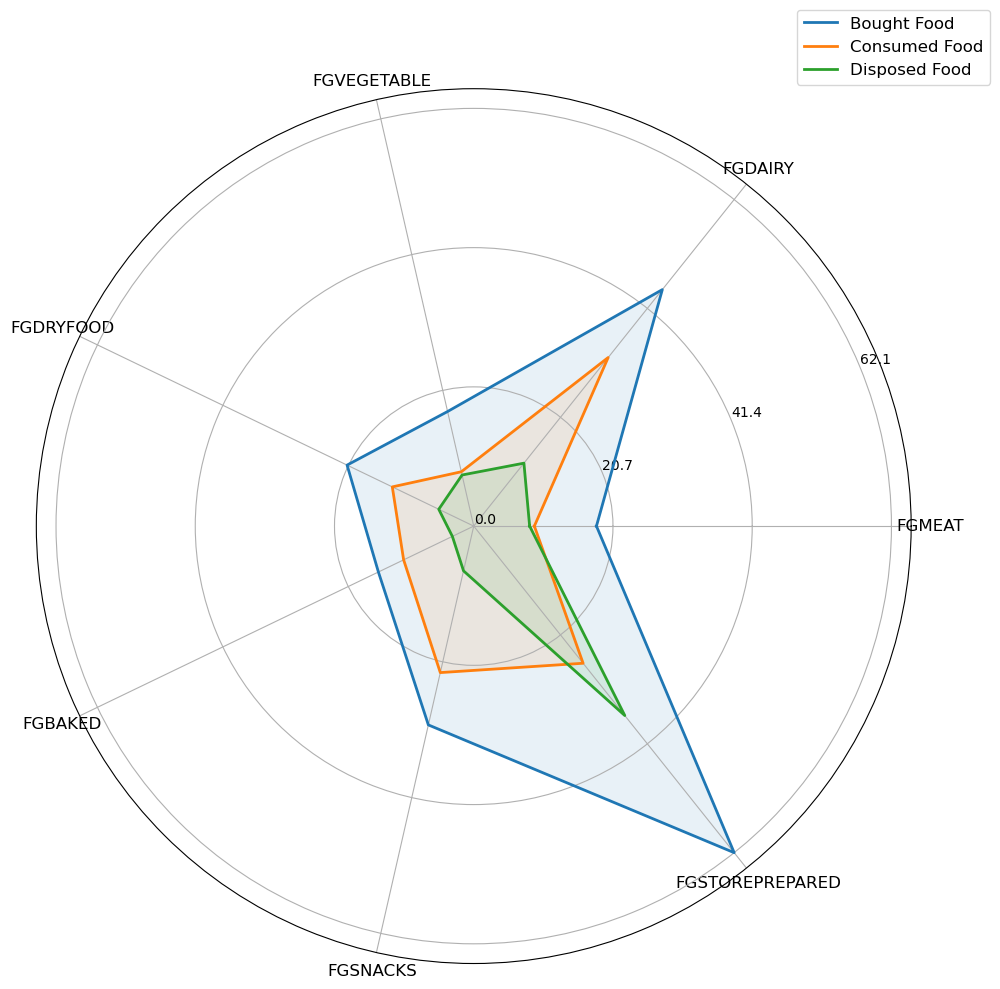

In [22]:
# Close the radar chart
values_bought = bought_sum.tolist() + [bought_sum.tolist()[0]]
values_ate = ate_sum.tolist() + [ate_sum.tolist()[0]]
values_wasted = wasted_sum.tolist() + [wasted_sum.tolist()[0]]

# Global max for consistent ring scaling
global_max = max(max(values_bought), max(values_ate), max(values_wasted))

# --- Radar Plot ---
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each category
ax.plot(angles, values_bought, label='Bought Food', linewidth=2)
ax.fill(angles, values_bought, alpha=0.1)

ax.plot(angles, values_ate, label='Consumed Food', linewidth=2)
ax.fill(angles, values_ate, alpha=0.1)

ax.plot(angles, values_wasted, label='Disposed Food', linewidth=2)
ax.fill(angles, values_wasted, alpha=0.1)

# Style
rings = np.linspace(0, global_max, 4)
ax.set_yticks(rings)
ax.set_yticklabels([f'{r:.1f}' for r in rings], fontsize=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(fg_names, fontsize=12)
#ax.set_title(f"Household {hhID}: Bought, Eaten, and Wasted by FG Category", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=12)

plt.tight_layout()
plt.show()


In [23]:
### -- Checking how much food was wasted per person and overall

In [24]:

sample_path = "/blue/carpena/haasehelen/ifwaste/input/gsua_based_configuration/samples/"
df_h = pd.read_csv( sample_path + "household_ifwaste_sample_df.txt", sep="\t") 
df_nh = pd.read_csv( sample_path + "neighborhood_ifwaste_sample_df.txt", sep="\t") 
df_sim = pd.read_csv( sample_path + "household_ifwaste_sample_df.txt", sep="\t")


In [25]:
df_h.columns

Index(['Household:hh_amount_children', 'Household:hh_amount_adults',
       'Household:hh_level_of_concern', 'Household:hh_impulse_buy_likelihood',
       'Household:hh_daily_budget', 'Household:hh_min_time_to_cook',
       'Household:hh_time_per_store', 'Household:hh_price_sensitivity',
       'Household:hh_brand_sensitivity', 'Household:hh_quality_sensitivity',
       'Household:hh_availability_sensitivity',
       'Household:hh_deal_sensitivity', 'Household:hh_planner',
       'Household:hh_impulsivity', 'Household:hh_brand_preference',
       'Adult:adult_plate_waste', 'Adult:male_store_prepared_ratio',
       'Adult:female_store_prepared_ratio', 'Child:child_plate_waste',
       'Child:male_store_prepared_ratio', 'Child:female_store_prepared_ratio',
       'Cooking:cook_max_scaler_cooking_amount',
       'Cooking:cook_expiration_threshold', 'Household:hh_shopping_frequency',
       'Household:hh_pay_day_interval', 'Household:hh_max_avail_time_per_day',
       'Adult:adult_preferen

In [ ]:
df_h = df_h.reset_index().rename(columns={"index": "household"})
df_h = df_h[["household","Household:hh_amount_children","Household:hh_amount_adults"]]
df_h.rename(columns={"Household:hh_amount_children":"amount_children", "Household:hh_amount_adults":"amount_adults"}, inplace=True)

: 

In [ ]:
wasted_with_people = pd.merge(left=df_h, right=wasted, on='household', how='inner')  # 'inner' is default
wasted_with_people = wasted_with_people.drop(columns=["days_till_expiry", "run", "price"])
wasted_with_people = wasted_with_people[wasted_with_people["day"] > 13]

In [ ]:
wasted_with_people

,household,amount_children,amount_adults,day,servings,status,reason,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,kg
221,0,0,2,14,0.222,Unprepared,Inedible Parts,0.0,0.000000,0.024864,0.000000,0.000000,0.0,0.0,0.024864
222,0,0,2,14,0.222,Unprepared,Inedible Parts,0.0,0.000000,0.024864,0.000000,0.000000,0.0,0.0,0.024864
223,0,0,2,14,0.222,Unprepared,Inedible Parts,0.0,0.000000,0.024864,0.000000,0.000000,0.0,0.0,0.024864
224,0,0,2,14,0.222,Unprepared,Inedible Parts,0.0,0.000000,0.024864,0.000000,0.000000,0.0,0.0,0.024864
225,0,0,2,14,0.081,Unprepared,Inedible Parts,0.0,0.011826,0.000000,0.000000,0.000000,0.0,0.0,0.011826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724662,1151,0,2,113,0.081,Unprepared,Inedible Parts,0.0,0.011826,0.000000,0.000000,0.000000,0.0,0.0,0.011826
3724663,1151,0,2,113,0.081,Unprepared,Inedible Parts,0.0,0.011826,0.000000,0.000000,0.000000,0.0,0.0,0.011826
3724664,1151,0,2,113,3.857,Prepared,Plate Waste,0.0,0.286160,0.000000,0.054036,0.084135,0.0,0.0,0.424331
3724665,1151,0,2,113,0.076,Prepared,Plate Waste,0.0,0.005548,0.000000,0.001064,0.001633,0.0,0.0,0.008245


In [ ]:
wasted_with_people.columns

Index(['household', 'amount_children', 'amount_adults', 'day', 'servings',
       'status', 'reason', 'FGMEAT', 'FGDAIRY', 'FGVEGETABLE', 'FGDRYFOOD',
       'FGSNACKS', 'FGBAKED', 'FGSTOREPREPARED', 'kg'],
      dtype='object')

In [ ]:

people_per_hh = wasted_with_people[["household", "amount_children", "amount_adults"]]
#structure_counts = pd.merge(people_per_hh, structure_counts, on="household")

#structure_counts = wasted_with_people.groupby(['amount_adults', 'amount_children'])['household'].count().reset_index()
#structure_counts.rename(columns={'household': 'n_households'}, inplace=True)
#structure_counts.head()
# Merge back into summed_fg
#summed_fg = pd.merge(summed_fg, structure_counts, on=['amount_adults', 'amount_children'], how='left')


In [ ]:
wasted_with_people

,household,amount_children,amount_adults,day,servings,status,reason,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,kg
221,0,0,2,14,0.222,Unprepared,Inedible Parts,0.0,0.000000,0.024864,0.000000,0.000000,0.0,0.0,0.024864
222,0,0,2,14,0.222,Unprepared,Inedible Parts,0.0,0.000000,0.024864,0.000000,0.000000,0.0,0.0,0.024864
223,0,0,2,14,0.222,Unprepared,Inedible Parts,0.0,0.000000,0.024864,0.000000,0.000000,0.0,0.0,0.024864
224,0,0,2,14,0.222,Unprepared,Inedible Parts,0.0,0.000000,0.024864,0.000000,0.000000,0.0,0.0,0.024864
225,0,0,2,14,0.081,Unprepared,Inedible Parts,0.0,0.011826,0.000000,0.000000,0.000000,0.0,0.0,0.011826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724662,1151,0,2,113,0.081,Unprepared,Inedible Parts,0.0,0.011826,0.000000,0.000000,0.000000,0.0,0.0,0.011826
3724663,1151,0,2,113,0.081,Unprepared,Inedible Parts,0.0,0.011826,0.000000,0.000000,0.000000,0.0,0.0,0.011826
3724664,1151,0,2,113,3.857,Prepared,Plate Waste,0.0,0.286160,0.000000,0.054036,0.084135,0.0,0.0,0.424331
3724665,1151,0,2,113,0.076,Prepared,Plate Waste,0.0,0.005548,0.000000,0.001064,0.001633,0.0,0.0,0.008245


In [ ]:
summed_fg = wasted_with_people.groupby('household')[fg_names + ["kg"]].sum().reset_index()


In [ ]:
summed_fg

,household,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGBAKED,FGSNACKS,FGSTOREPREPARED,kg
0,0,15.181175,18.286792,31.503808,13.730464,14.689290,15.585849,44.4792,153.456578
1,1,14.456092,28.780542,7.205184,12.843392,3.251270,19.779890,54.1927,140.509070
2,2,69.691628,136.152884,98.184912,55.202980,56.328140,55.270873,112.6910,583.522417
3,3,25.081001,72.635876,34.063456,20.270872,13.439635,43.147197,83.1979,291.835937
4,4,6.753854,9.703890,5.036976,4.558252,2.704680,5.230073,29.9317,63.919425
...,...,...,...,...,...,...,...,...,...
1147,1147,10.283327,27.191916,17.497760,9.050688,3.056515,12.899635,28.6596,108.639441
1148,1148,16.657774,47.552054,10.721312,12.686984,1.852675,18.566500,33.8832,141.920499
1149,1149,10.670032,22.026436,12.647264,7.801552,2.896685,9.863817,26.1368,92.042586
1150,1150,9.792136,12.445332,7.655088,3.916432,3.657500,5.741841,24.2061,67.414429


In [ ]:
summed_fg

,household,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGBAKED,FGSNACKS,FGSTOREPREPARED,kg
0,0,15.181175,18.286792,31.503808,13.730464,14.689290,15.585849,44.4792,153.456578
1,1,14.456092,28.780542,7.205184,12.843392,3.251270,19.779890,54.1927,140.509070
2,2,69.691628,136.152884,98.184912,55.202980,56.328140,55.270873,112.6910,583.522417
3,3,25.081001,72.635876,34.063456,20.270872,13.439635,43.147197,83.1979,291.835937
4,4,6.753854,9.703890,5.036976,4.558252,2.704680,5.230073,29.9317,63.919425
...,...,...,...,...,...,...,...,...,...
1147,1147,10.283327,27.191916,17.497760,9.050688,3.056515,12.899635,28.6596,108.639441
1148,1148,16.657774,47.552054,10.721312,12.686984,1.852675,18.566500,33.8832,141.920499
1149,1149,10.670032,22.026436,12.647264,7.801552,2.896685,9.863817,26.1368,92.042586
1150,1150,9.792136,12.445332,7.655088,3.916432,3.657500,5.741841,24.2061,67.414429


In [ ]:
# Aggregate by reason (overall)


stats_reason = wasted_with_people.pivot_table(
    index='household',
    columns='reason',
    values='kg',
    aggfunc='sum',
    fill_value=0
)
stats_reason.columns = [f"{col}" for col in stats_reason.columns]
stats_reason = stats_reason.reset_index()
stats_reason

,household,Inedible Parts,Plate Waste,Spoiled Food
0,0,24.622859,31.382099,97.451620
1,1,19.191136,33.312971,88.004963
2,2,94.704371,207.482948,281.335098
3,3,47.755905,188.904544,55.175488
4,4,9.646594,18.037518,36.235313
...,...,...,...,...
1147,1147,18.354126,88.273715,2.011600
1148,1148,22.204351,98.922656,20.793492
1149,1149,16.171524,75.175062,0.696000
1150,1150,13.412743,29.023358,24.978328


In [ ]:

stats_status = wasted_with_people.pivot_table(
    index='household',
    columns='status',
    values='kg',
    aggfunc='sum',
    fill_value=0
)
stats_status.columns = [f"{col}" for col in stats_status.columns]
stats_status = stats_status.reset_index()
stats_status

,household,Prepared,Preprepared,Unprepared
0,0,65.432867,44.4792,43.544511
1,1,67.828420,54.1927,18.487950
2,2,336.000886,112.6910,134.830531
3,3,160.091843,83.1979,48.546194
4,4,22.280291,29.9317,11.707434
...,...,...,...,...
1147,1147,61.708015,28.6596,18.271826
1148,1148,86.865196,33.8832,21.172103
1149,1149,49.762762,26.1368,16.143024
1150,1150,22.913963,24.2061,20.294366


: 

In [ ]:
merged = pd.merge(summed_fg, stats_reason, on='household', how='inner')  # 'inner' is default
merged = pd.merge(merged, stats_status, on='household', how='inner')  # 'inner' is default
merged = pd.merge(merged, people_per_hh, on='household', how='inner')  # 'inner' is default
merged 


In [ ]:
merged

NameError: name 'merged' is not defined

In [ ]:

# Group by amount_adults and amount_children and calculate mean and std of Total_Food_Waste
#food_waste_summary = merged.groupby(['amount_adults', 'amount_children'])['kg'].agg(['mean', 'std']).reset_index()

#print(food_waste_summary)

KeyError: 'Column not found: kg'

In [ ]:
merged.columns

Index(['household', 'FGMEAT', 'FGDAIRY', 'FGVEGETABLE', 'FGDRYFOOD', 'FGBAKED',
       'FGSNACKS', 'FGSTOREPREPARED', 'kg', 'Inedible Parts', 'Plate Waste',
       'Spoiled Food', 'Prepared', 'Preprepared', 'Unprepared'],
      dtype='object')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your categories
categories = ['Inedible Parts', 'Spoiled Food', 'Plate Waste']
num_vars = len(categories)

# Radar angles
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Optional: custom color palette
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Create a label for each group (family size)
merged['family_label'] = merged['amount_adults'].astype(str) + 'A_' + merged['amount_children'].astype(str) + 'C'

# Compute global max for consistent radar scaling
global_max = merged[categories].max().max()

# Plot config
n_subplots = len(merged)
cols = 3  # Number of subplots per row
rows = int(np.ceil(n_subplots / cols))

fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), subplot_kw=dict(polar=True))
axs = axs.flatten()

for i, (idx, row) in enumerate(merged.iterrows()):
    ax = axs[i]

    values = row[categories].tolist()
    values += values[:1]  # Close circle

    # Plot
    ax.plot(angles, values, color=colors[i % len(colors)], linewidth=2)
    ax.fill(angles, values, color=colors[i % len(colors)], alpha=0.25)

    # Setup
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_yticks(np.linspace(0, global_max, 4))
    ax.set_yticklabels([f"{v:.2f}" for v in np.linspace(0, global_max, 4)], fontsize=10)
    ax.set_title(f"{row['adults']} Adults, {row['children']} Children", fontsize=13, pad=20)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


KeyError: 'amount_adults'